<a href="https://colab.research.google.com/github/John-Akech/Summative-Assignment---Model-Training-and-Evaluation/blob/master/Summative_Assignment_Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FloodSense South Sudan: Machine Learning-Based Flood Prediction and Early Warning System

## Project Overview
This notebook details the implementation of machine learning models with optimization techniques to improve performance, convergence speed, and efficiency in predicting floods in South Sudan. The project aims to create a localized flood prediction and early warning system using historical flood data, meteorological records.

## Dataset Acquisition
For this project, we will use the Kaggle dataset for historical flood data and meteorological records.

### Brief Description of the Problem
South Sudan is highly vulnerable to floods due to its low-lying terrain and inadequate drainage infrastructure. The goal is to develop a machine learning model that can predict floods and provide early warnings to mitigate the impact on communities.

In [63]:
# Load Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import joblib
import os

In [64]:
# Create Directory to Save Models
os.makedirs('saved_models', exist_ok=True)

In [65]:
# Load the Dataset
def load_data(file_path):
    """Load the dataset from a CSV file."""
    data = pd.read_csv(file_path)
    return data

file_path = '/content/flood.csv'
data = load_data(file_path)

In [66]:
# Data Exploration
def explore_data(data):
    """Explore the dataset for initial insights."""
    print("Original dataset size:", data.shape)
    print("\nMissing values in the dataset:")
    print(data.isnull().sum())
    print("\nData types in the dataset:")
    print(data.dtypes)
    print("\nNumber of duplicates in the dataset:", data.duplicated().sum())
    return data

data = explore_data(data)

Original dataset size: (50000, 21)

Missing values in the dataset:
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

Data types in the dataset:
MonsoonIntensity                     int64
TopographyDrainage                   int64
RiverManagement              

In [67]:
# Data Preprocessing
def preprocess_data(data):
    """Preprocess the dataset by encoding target variable and checking basic statistics."""
    data['FloodRisk'] = pd.cut(data['FloodProbability'], bins=[0, 0.4, 0.6, 1], labels=['Low', 'Medium', 'High'])
    data['FloodRisk'] = data['FloodRisk'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(int)
    print("\nBasic Statistics Of The Dataset:")
    print(data.describe())
    return data

data_encoded = preprocess_data(data)


Basic Statistics Of The Dataset:
       MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
count      50000.000000        50000.000000      50000.00000   50000.000000   
mean           4.991480            4.984100          5.01594       5.008480   
std            2.236834            2.246488          2.23131       2.222743   
min            0.000000            0.000000          0.00000       0.000000   
25%            3.000000            3.000000          3.00000       3.000000   
50%            5.000000            5.000000          5.00000       5.000000   
75%            6.000000            6.000000          6.00000       6.000000   
max           16.000000           18.000000         16.00000      17.000000   

       Urbanization  ClimateChange  DamsQuality     Siltation  \
count  50000.000000   50000.000000  50000.00000  50000.000000   
mean       4.989060       4.988340      5.01536      4.988600   
std        2.243159       2.226761      2.24500      2.2326

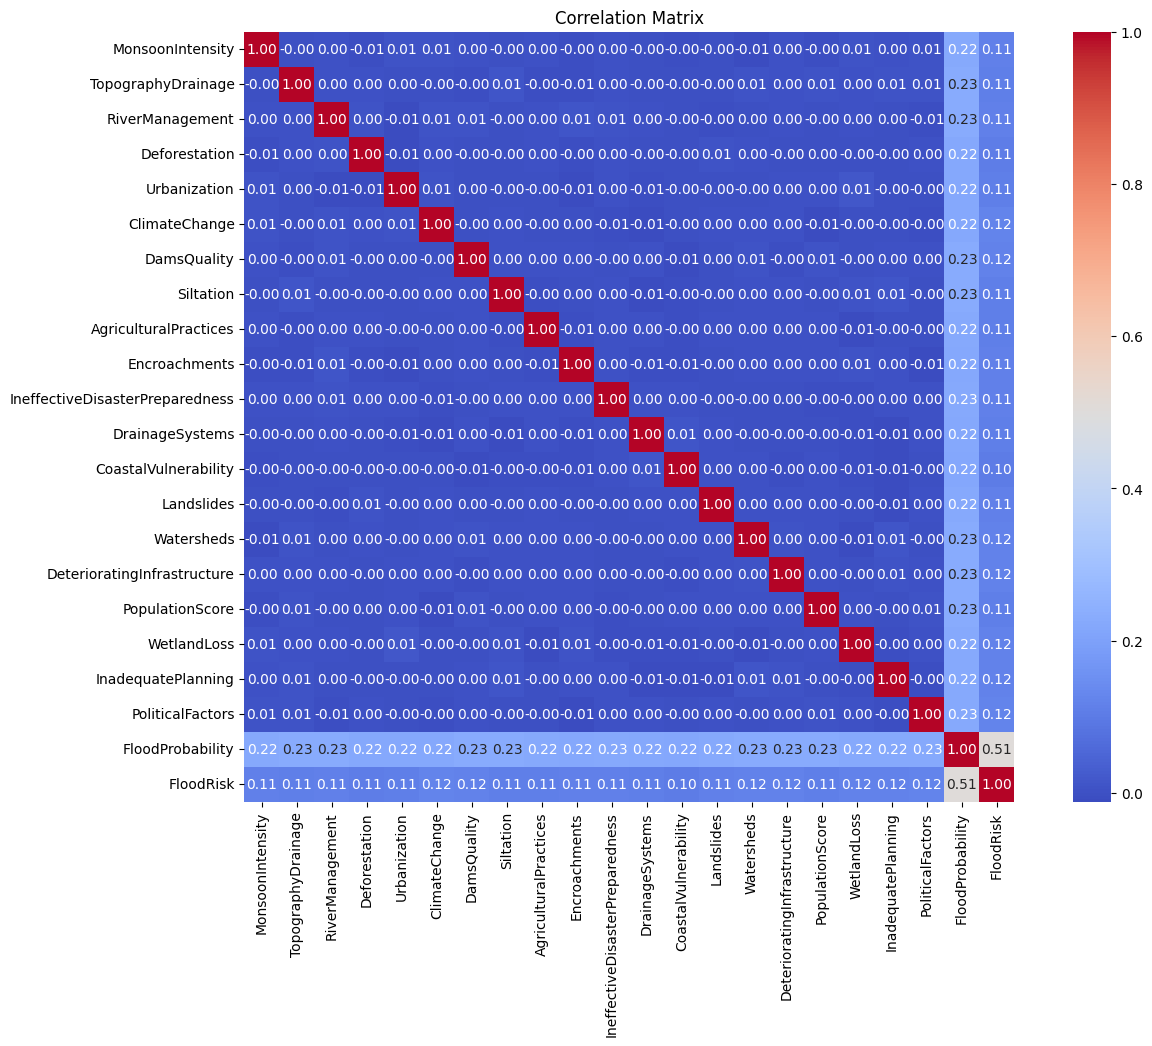

In [68]:
# Plot Correlation Matrix
def plot_correlation_matrix(data):
    """Plot the correlation matrix to understand relationships between features."""
    plt.figure(figsize=(15, 10))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(data_encoded)


Class Distribution:
FloodRisk
1    47731
0     1136
2     1133
Name: count, dtype: int64


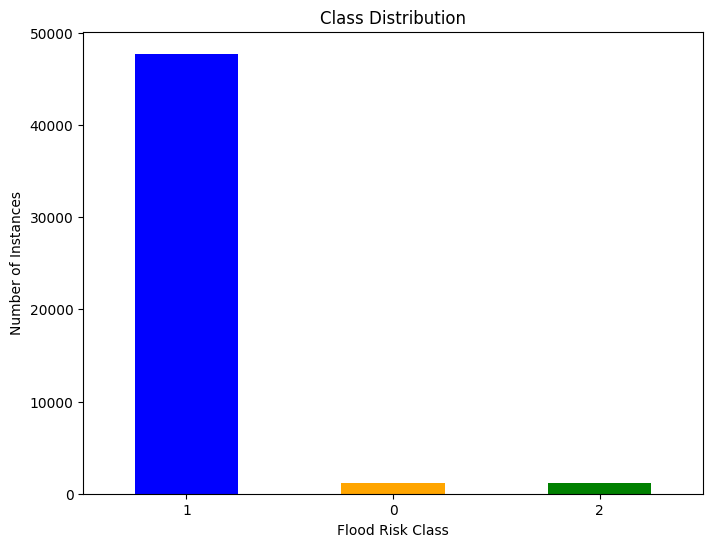

In [69]:
# Visualize Class Distribution
def visualize_class_distribution(data):
    """Visualize the distribution of classes in the target variable."""
    class_distribution = data['FloodRisk']. value_counts()
    print("\nClass Distribution:")
    print(class_distribution)

    plt.figure(figsize=(8, 6))
    class_distribution.plot(kind='bar', color=['blue', 'orange', 'green'])
    plt.title('Class Distribution')
    plt.xlabel('Flood Risk Class')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=0)
    plt.show()

visualize_class_distribution(data_encoded)


Class counts after handling imbalance:
FloodRisk
0    1136
1    1136
2    1136
Name: count, dtype: int64


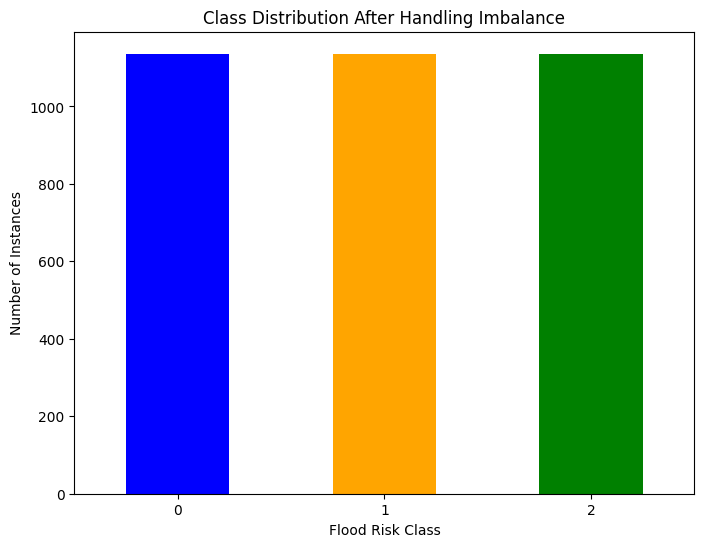

In [70]:
# Handle Class Imbalance
def handle_imbalance(data):
    """Handle class imbalance using random oversampling."""
    majority_class = data[data['FloodRisk'] == 0]  # Low
    medium_class = data[data['FloodRisk'] == 1]    # Medium
    minority_class = data[data['FloodRisk'] == 2]  # High

    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
    medium_upsampled = resample(medium_class, replace=True, n_samples=len(majority_class), random_state=42)

    upsampled_data = pd.concat([majority_class, medium_upsampled, minority_upsampled])
    print("\nClass counts after handling imbalance:")
    print(upsampled_data['FloodRisk'].value_counts())

    # Visualize the class distribution after handling imbalance
    plt.figure(figsize=(8, 6))
    upsampled_data['FloodRisk'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
    plt.title('Class Distribution After Handling Imbalance')
    plt.xlabel('Flood Risk Class')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=0)
    plt.show()

    return upsampled_data

upsampled_data_cleaned = handle_imbalance(data_encoded)

In [71]:
# Define the function to check for outliers
def check_for_outliers(data):
    """Check for outliers in the dataset."""
    Q1 = data['FloodProbability'].quantile(0.25)
    Q3 = data['FloodProbability'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data['FloodProbability'] < lower_bound) | (data['FloodProbability'] > upper_bound)]
    return outliers

In [72]:
# Call the function and print the number of outliers
outliers = check_for_outliers(upsampled_data_cleaned)
print("Number of Outliers Detected:", outliers.shape[0])

Number of Outliers Detected: 0


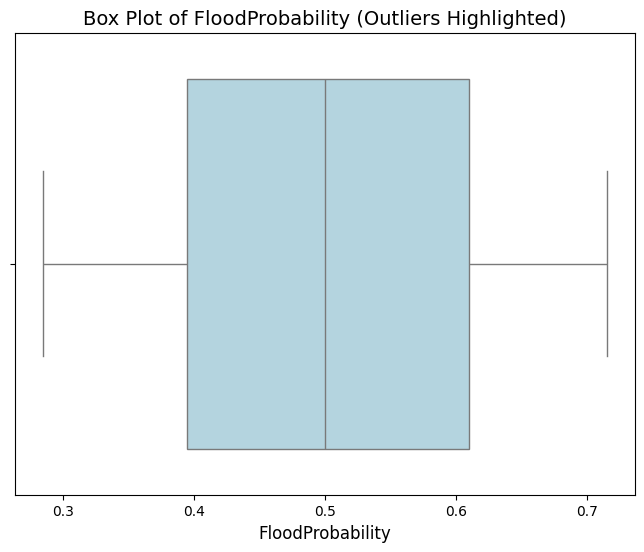

In [73]:
# Plot a box plot to visualize the outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=upsampled_data_cleaned['FloodProbability'], color='lightblue')
plt.title('Box Plot of FloodProbability (Outliers Highlighted)', fontsize=14)
plt.xlabel('FloodProbability', fontsize=12)
plt.show()

In [74]:
# Prepare Data for Modeling
X = upsampled_data_cleaned.drop(['FloodRisk', 'FloodProbability'], axis=1)
y = upsampled_data_cleaned['FloodRisk']

In [75]:
# Split the Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [76]:
# Scale the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
# Create a Validation Set from the Training Data
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [78]:
# Define Model Function
def define_model(optimization: str, regularization: float, early_stopping: bool, dropout: float, learning_rate: float):
    """Define and compile the neural network model."""
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))  # Input layer
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(regularization)))  # First hidden layer
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))  # Second hidden layer
    model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu'))  # Third hidden layer
    model.add(Dropout(dropout))
    model.add(Dense(16, activation='relu'))  # Fourth hidden layer
    model.add(Dense(3, activation='softmax'))  # Output layer for multiclass classification

    optimizer = Adam(learning_rate=learning_rate) if optimization == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)] if early_stopping else []
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, callbacks=callbacks, verbose=0)

    # Save the model architecture as an image
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Model architecture saved as 'model_architecture.png'.")

    return model, history

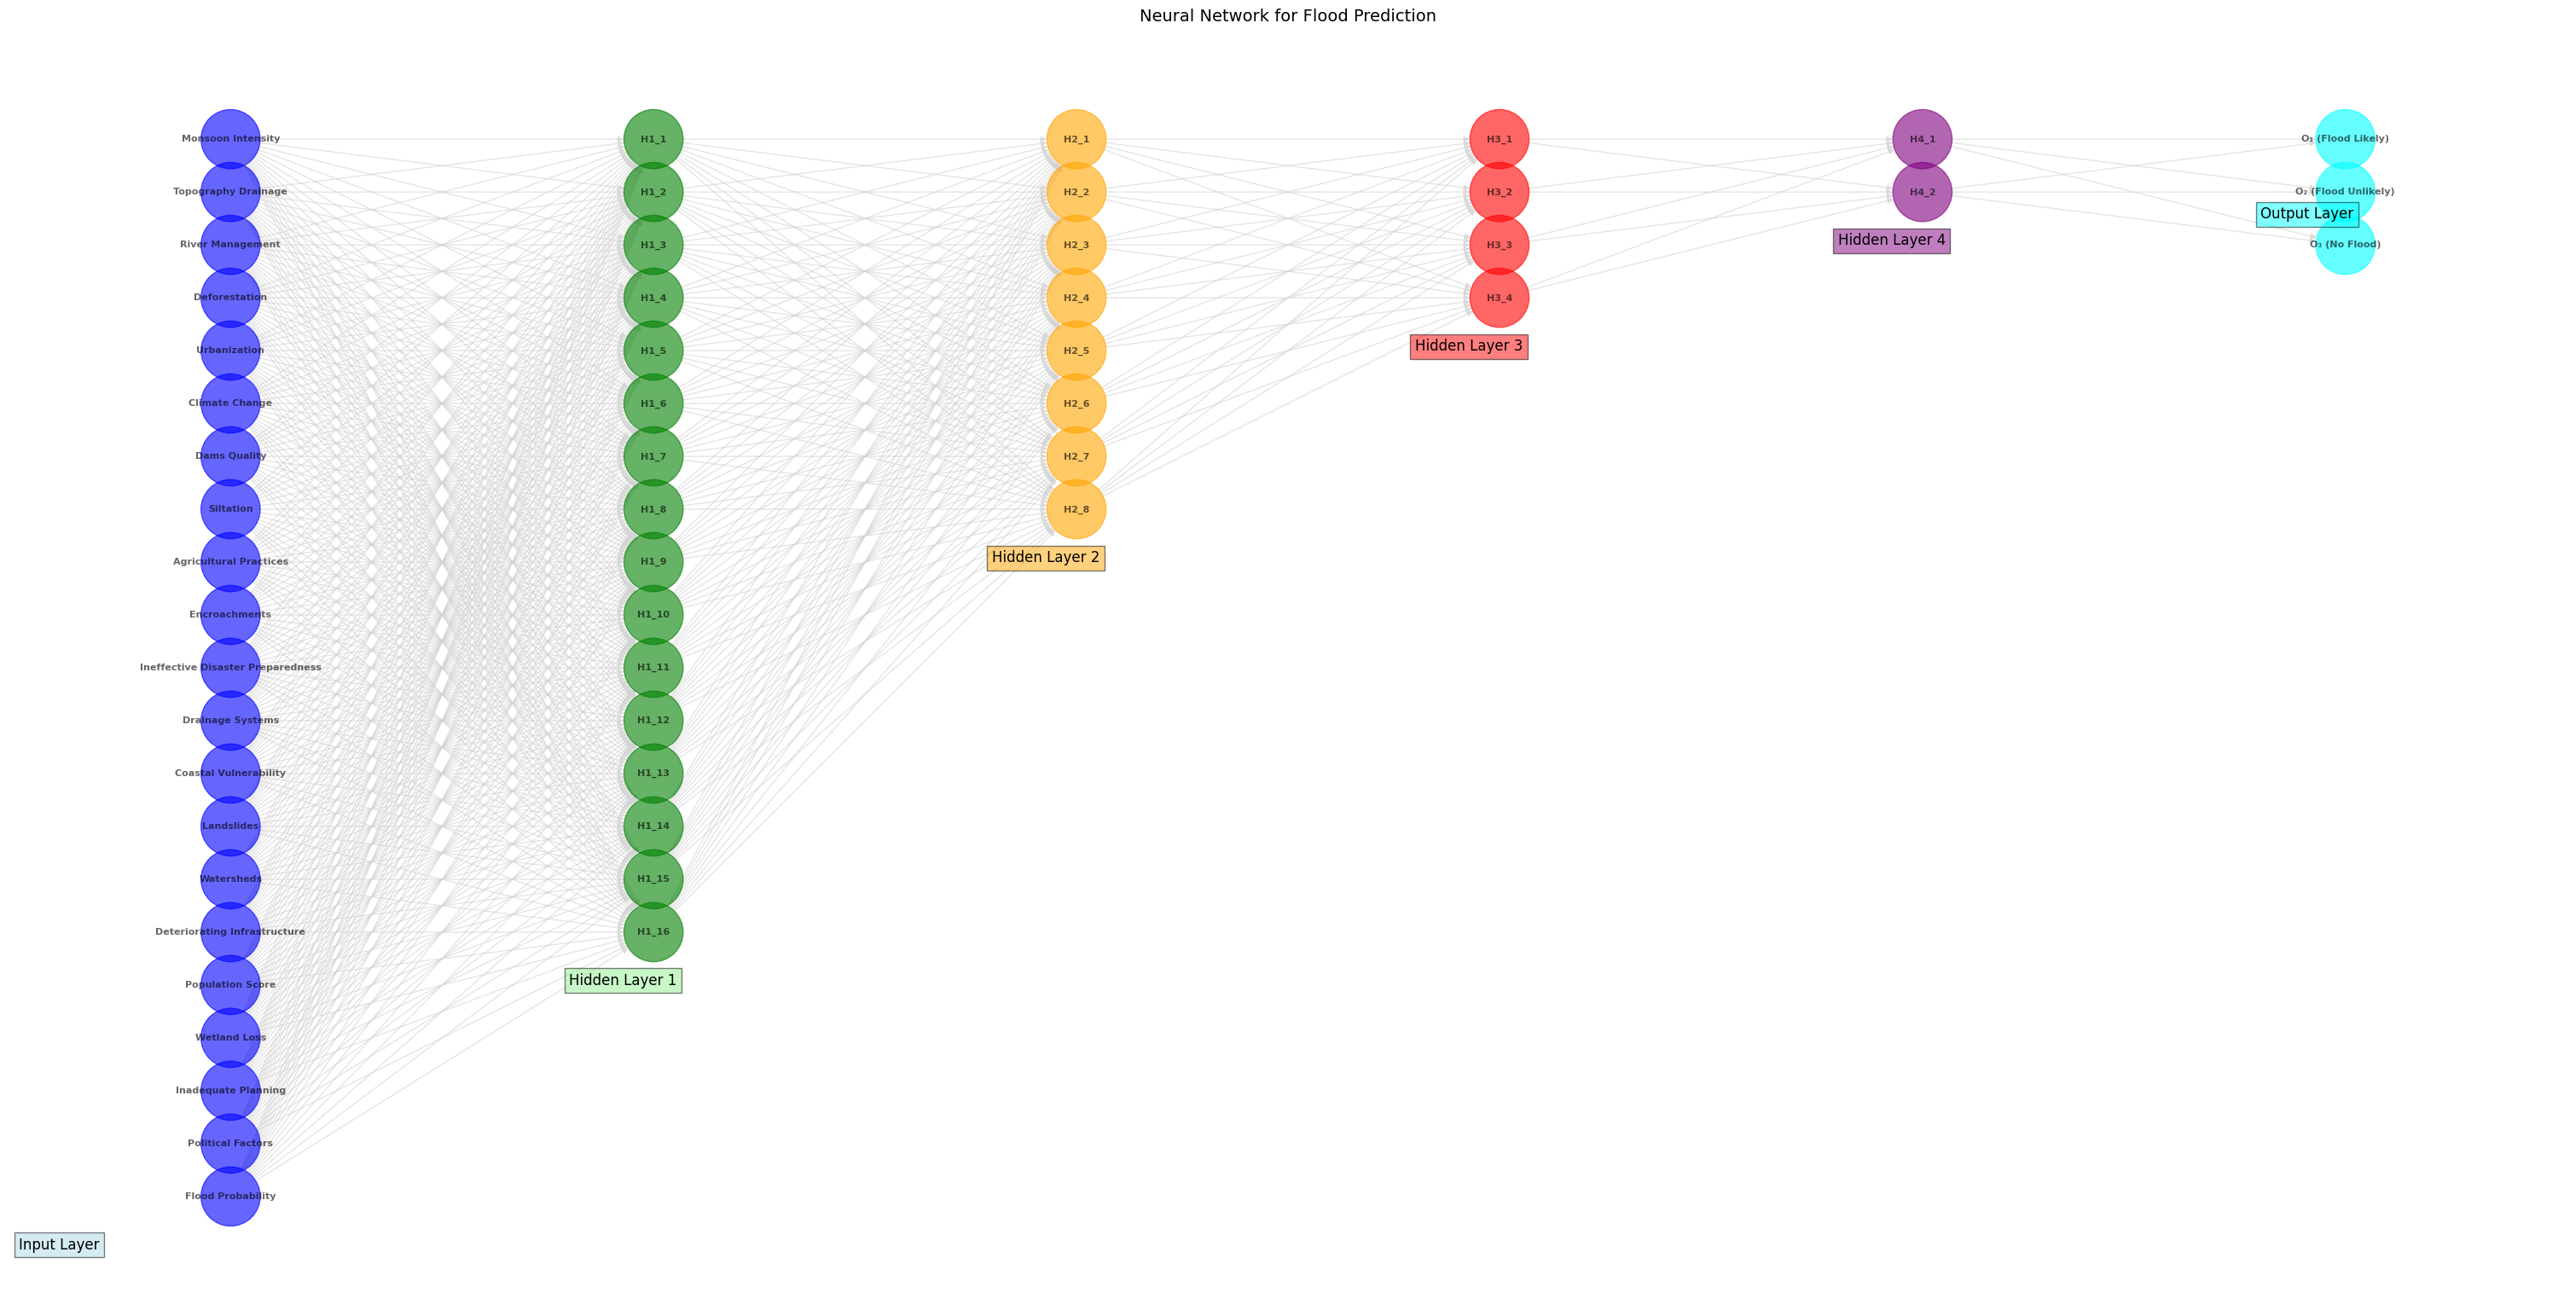

In [79]:
import networkx as nx
import matplotlib.pyplot as plt

# Define layers based on your features
input_neurons = [
    'Monsoon Intensity', 'Topography Drainage', 'River Management',
    'Deforestation', 'Urbanization', 'Climate Change',
    'Dams Quality', 'Siltation', 'Agricultural Practices',
    'Encroachments', 'Ineffective Disaster Preparedness',
    'Drainage Systems', 'Coastal Vulnerability', 'Landslides',
    'Watersheds', 'Deteriorating Infrastructure', 'Population Score',
    'Wetland Loss', 'Inadequate Planning', 'Political Factors',
    'Flood Probability'
]

hidden_layer_1 = [f'H1_{i}' for i in range(1, 17)]  # 16 neurons in the first hidden layer
hidden_layer_2 = [f'H2_{i}' for i in range(1, 9)]   # 8 neurons in the second hidden layer
hidden_layer_3 = [f'H3_{i}' for i in range(1, 5)]   # 4 neurons in the third hidden layer
hidden_layer_4 = [f'H4_{i}' for i in range(1, 3)]   # 2 neurons in the fourth hidden layer
output_neurons = ['O₁ (Flood Likely)', 'O₂ (Flood Unlikely)', 'O₃ (No Flood)']  # 3 output neurons

# Create a directed graph
G = nx.DiGraph()

# Define X-axis positions for each layer
layer_positions = {
    'input': 0,
    'hidden_1': 1,
    'hidden_2': 2,
    'hidden_3': 3,
    'hidden_4': 4,
    'output': 5
}

# Add nodes
pos = {}  # Store positions of nodes for plotting

# Add input layer nodes
for i, neuron in enumerate(input_neurons):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['input'], -i)

# Add hidden layer 1 nodes
for i, neuron in enumerate(hidden_layer_1):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['hidden_1'], -i)

# Add hidden layer 2 nodes
for i, neuron in enumerate(hidden_layer_2):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['hidden_2'], -i)

# Add hidden layer 3 nodes
for i, neuron in enumerate(hidden_layer_3):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['hidden_3'], -i)

# Add hidden layer 4 nodes
for i, neuron in enumerate(hidden_layer_4):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['hidden_4'], -i)

# Add output layer nodes
for i, neuron in enumerate(output_neurons):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['output'], -i)

# Connect input layer to hidden layer 1
for input_neuron in input_neurons:
    for h1_neuron in hidden_layer_1:
        G.add_edge(input_neuron, h1_neuron)

# Connect hidden layer 1 to hidden layer 2
for h1_neuron in hidden_layer_1:
    for h2_neuron in hidden_layer_2:
        G.add_edge(h1_neuron, h2_neuron)

# Connect hidden layer 2 to hidden layer 3
for h2_neuron in hidden_layer_2:
    for h3_neuron in hidden_layer_3:
        G.add_edge(h2_neuron, h3_neuron)

# Connect hidden layer 3 to hidden layer 4
for h3_neuron in hidden_layer_3:
    for h4_neuron in hidden_layer_4:
        G.add_edge(h3_neuron, h4_neuron)

# Connect hidden layer 4 to output layer
for h4_neuron in hidden_layer_4:
    for output_neuron in output_neurons:
        G.add_edge(h4_neuron, output_neuron)

# Define colors for different layers
color_map = {**{node: 'blue' for node in input_neurons},
             **{node: 'green' for node in hidden_layer_1},
             **{node: 'orange' for node in hidden_layer_2},
             **{node: 'red' for node in hidden_layer_3},
             **{node: 'purple' for node in hidden_layer_4},
             **{node: 'cyan' for node in output_neurons}}

# Draw the network
plt.figure(figsize=(30, 15))
nx.draw(G, pos, with_labels=True, node_size=2500, font_size=8, font_weight='bold',
        node_color=[color_map[node] for node in G.nodes()], edge_color='lightgray', alpha=0.6)

# Add layer labels
plt.text(-0.5, -21, "Input Layer", fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(0.8, -16, "Hidden Layer 1", fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.text(1.8, -8, "Hidden Layer 2", fontsize=12, bbox=dict(facecolor='orange', alpha=0.5))
plt.text(2.8, -4, "Hidden Layer 3", fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
plt.text(3.8, -2, "Hidden Layer 4", fontsize=12, bbox=dict(facecolor='purple', alpha=0.5))
plt.text(4.8, -1.5, "Output Layer", fontsize=12, bbox=dict (facecolor='cyan', alpha=0.5))

plt.title("Neural Network for Flood Prediction", fontsize=14)
plt.show()

In [80]:
# Function to Evaluate Models
def evaluate_model(model, X_test, y_test):
    """Evaluate the model's performance."""

    # Get predicted probabilities for each class
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)  # Use predict_proba for probability estimates
    else:
        y_pred_prob = model.predict(X_test)  # Fallback to predict if predict_proba is not available

    # Calculate ROC AUC score for multiclass classification
    try:
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')  # Use 'ovr' for multiclass
    except ValueError as e:
        print(f"Error calculating ROC AUC Score: {e}")
        roc_auc = np.nan  # Set to NaN if calculation fails

    y_pred = np.argmax(y_pred_prob, axis=1)  # Get the predicted class
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    report = classification_report(y_test, y_pred, output_dict=True)

    return {
        'ROC AUC Score': roc_auc,
        'Accuracy': accuracy,  # Include accuracy in the results
        'Error Metrics': {
            'F1 Score': report['1']['f1-score'],
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall']
        },
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

In [81]:
# Function to Plot Loss Curves
def loss_curve_plot(history):
    """Plot training and validation loss curves."""
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [82]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, model_name):
    """Plot the confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [83]:
# Train and Evaluate Models
def train_and_evaluate_model(optimizer, regularization, early_stopping, dropout, learning_rate, model_name):
    """Train and evaluate the model."""
    model, history = define_model(optimizer, regularization, early_stopping, dropout, learning_rate)
    model.save(f'saved_models/{model_name}.h5')
    loss_curve_plot(history)
    metrics = evaluate_model(model, X_test_scaled, y_test)
    print(f"\n{model_name} Metrics:")
    print("ROC AUC Score:", metrics['ROC AUC Score'])
    print("Accuracy:", metrics['Accuracy'])
    print("Error Metrics:", metrics['Error Metrics'])
    print("Confusion Matrix:\n", metrics['Confusion Matrix'])
    return metrics

Model architecture saved as 'model_architecture.png'.


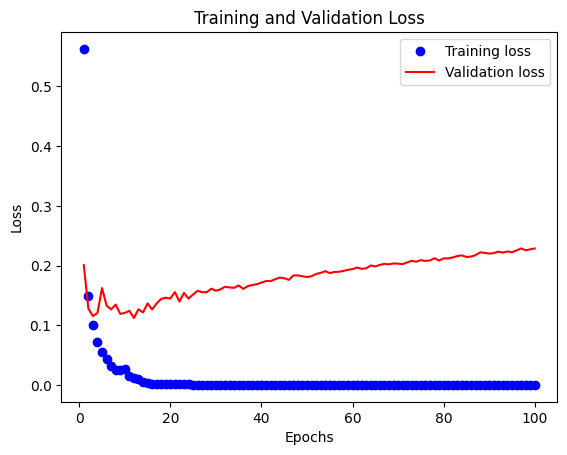

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

model_1 Metrics:
ROC AUC Score: 0.9954064535562331
Accuracy: 0.966275659824047
Error Metrics: {'F1 Score': 0.9490022172949002, 'Precision': 0.9553571428571429, 'Recall': 0.9427312775330396}
Confusion Matrix:
 [[225   2   0]
 [  6 214   7]
 [  0   8 220]]


In [84]:
# Train and Evaluate Neural Network Models
# Model 1: Simple Neural Network (No Optimization)
metrics_1 = train_and_evaluate_model('adam', 0.0, False, 0.0, 0.001, 'model_1')

Model architecture saved as 'model_architecture.png'.


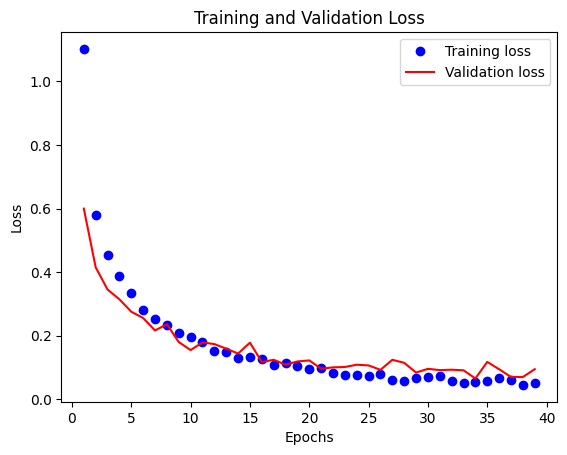

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

model_2 Metrics:
ROC AUC Score: 0.9969259036555581
Accuracy: 0.9809384164222874
Error Metrics: {'F1 Score': 0.970917225950783, 'Precision': 0.9863636363636363, 'Recall': 0.9559471365638766}
Confusion Matrix:
 [[227   0   0]
 [  6 217   4]
 [  0   3 225]]


In [85]:
# Model 2: Neural Network with Regularization, Early Stopping, and Dropout
metrics_2 = train_and_evaluate_model('adam', 0.01, True, 0.2, 0.001, 'model_2')

Model architecture saved as 'model_architecture.png'.


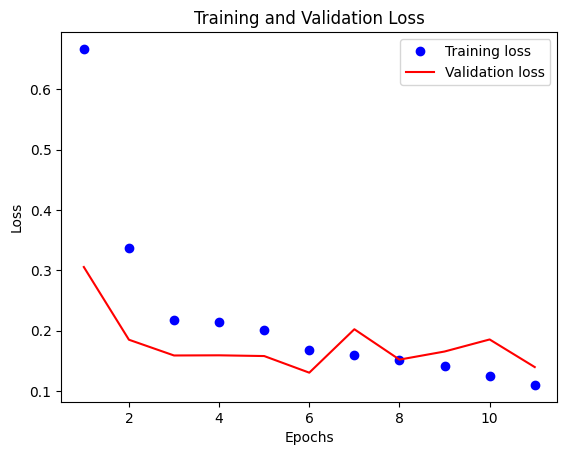

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

model_3 Metrics:
ROC AUC Score: 0.9934578412030302
Accuracy: 0.9618768328445748
Error Metrics: {'F1 Score': 0.9398148148148148, 'Precision': 0.9902439024390244, 'Recall': 0.8942731277533039}
Confusion Matrix:
 [[227   0   0]
 [ 12 203  12]
 [  0   2 226]]


In [86]:
# Model 3: Neural Network with RMSprop Optimizer and Early Stopping
metrics_3 = train_and_evaluate_model('rmsprop', 0.0, True, 0.2, 0.001, 'model_3')

Model architecture saved as 'model_architecture.png'.


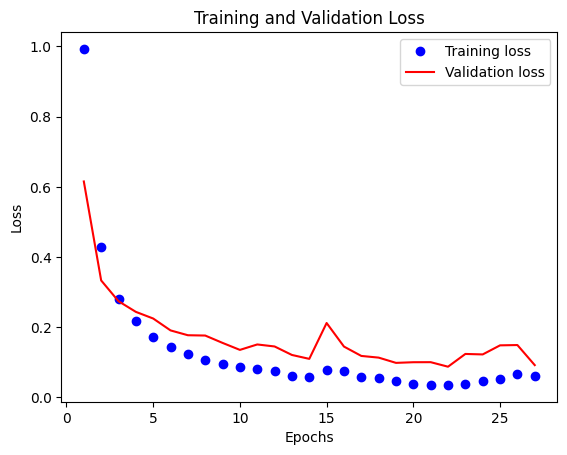

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

model_4 Metrics:
ROC AUC Score: 0.9971001504099116
Accuracy: 0.9765395894428153
Error Metrics: {'F1 Score': 0.9642857142857143, 'Precision': 0.9773755656108597, 'Recall': 0.9515418502202643}
Confusion Matrix:
 [[227   0   0]
 [  6 216   5]
 [  0   5 223]]


In [87]:
# Model 4: Neural Network with Regularization and Early Stopping
metrics_4 = train_and_evaluate_model('adam', 0.01, True, 0.0, 0.001, 'model_4')

Model architecture saved as 'model_architecture.png'.


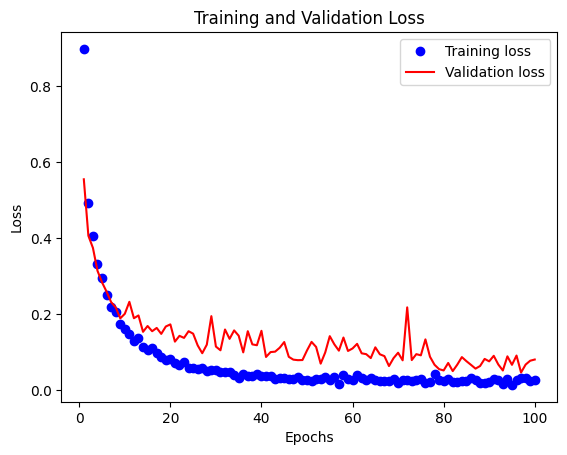

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

model_5 Metrics:
ROC AUC Score: 0.9979710090769678
Accuracy: 0.9853372434017595
Error Metrics: {'F1 Score': 0.9774774774774775, 'Precision': 1.0, 'Recall': 0.9559471365638766}
Confusion Matrix:
 [[227   0   0]
 [  6 217   4]
 [  0   0 228]]


In [88]:
# Model 5: Neural Network with RMSprop Optimizer, Regularization, and Dropout
metrics_5 = train_and_evaluate_model('rmsprop', 0.01, False, 0.1, 0.001, 'model_5')

In [89]:
# Train and Evaluate Classical Models
# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc_ovr')  # Use 'roc_auc_ovr' for multiclass
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_model = rf_grid_search.best_estimator_
metrics_rf = evaluate_model(rf_best_model, X_test_scaled, y_test)

In [90]:
# Print Random Forest Metrics and Tuned Hyperparameters
print(f"\nRandom Forest Metrics:")
print("ROC AUC Score:", metrics_rf['ROC AUC Score'])
print("Accuracy:", metrics_rf['Accuracy'])
print("Error Metrics:", metrics_rf['Error Metrics'])
print("Confusion Matrix:\n", metrics_rf['Confusion Matrix'])
print("Tuned Hyperparameters:", rf_grid_search.best_params_)


Random Forest Metrics:
ROC AUC Score: 0.9830371633930642
Accuracy: 0.9222873900293255
Error Metrics: {'F1 Score': 0.8775981524249422, 'Precision': 0.9223300970873787, 'Recall': 0.8370044052863436}
Confusion Matrix:
 [[225   2   0]
 [ 23 190  14]
 [  0  14 214]]
Tuned Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [91]:
# Save Random Forest model
joblib.dump(rf_best_model, 'saved_models/random_forest_model.pkl')

['saved_models/random_forest_model.pkl']

In [92]:
# XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='roc_auc_ovr')  # Use 'roc_auc_ovr' for multiclass
xgb_grid_search.fit(X_train_scaled, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
metrics_xgb = evaluate_model(xgb_best_model, X_test_scaled, y_test)

In [93]:
# Print XGBoost Metrics and Tuned Hyperparameters
print(f"\nXGBoost Metrics:")
print("ROC AUC Score:", metrics_xgb['ROC AUC Score'])
print("Accuracy:", metrics_xgb['Accuracy'])
print("Error Metrics:", metrics_xgb['Error Metrics'])
print("Confusion Matrix:\n", metrics_xgb['Confusion Matrix'])
print("Tuned Hyperparameters:", xgb_grid_search.best_params_)


XGBoost Metrics:
ROC AUC Score: 0.9872690098113237
Accuracy: 0.9428152492668622
Error Metrics: {'F1 Score': 0.9099307159353349, 'Precision': 0.9563106796116505, 'Recall': 0.8678414096916299}
Confusion Matrix:
 [[225   2   0]
 [ 17 197  13]
 [  0   7 221]]
Tuned Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [94]:
# Save XGBoost model
joblib.dump(xgb_best_model, 'saved_models/xgboost_model.pkl')

['saved_models/xgboost_model.pkl']

In [95]:
# Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

log_reg_grid_search = GridSearchCV(log_reg_model, log_reg_param_grid, cv=5, scoring='roc_auc_ovr')  # Use 'roc_auc_ovr' for multiclass
log_reg_grid_search.fit(X_train_scaled, y_train)
log_reg_best_model = log_reg_grid_search.best_estimator_
metrics_log_reg = evaluate_model(log_reg_best_model, X_test_scaled, y_test)

In [96]:
# Print Logistic Regression Metrics and Tuned Hyperparameters
print(f"\nLogistic Regression Metrics:")
print("ROC AUC Score:", metrics_log_reg['ROC AUC Score'])
print("Accuracy:", metrics_log_reg['Accuracy'])
print("Error Metrics:", metrics_log_reg['Error Metrics'])
print("Confusion Matrix:\n", metrics_log_reg['Confusion Matrix'])
print("Tuned Hyperparameters:", log_reg_grid_search.best_params_)


Logistic Regression Metrics:
ROC AUC Score: 0.9997226419148516
Accuracy: 0.9897360703812317
Error Metrics: {'F1 Score': 0.9843400447427293, 'Precision': 1.0, 'Recall': 0.9691629955947136}
Confusion Matrix:
 [[227   0   0]
 [  4 220   3]
 [  0   0 228]]
Tuned Hyperparameters: {'C': 10, 'solver': 'saga'}


In [97]:
# Save Logistic Regression model
joblib.dump(log_reg_best_model, 'saved_models/logistic_regression_model.pkl')

['saved_models/logistic_regression_model.pkl']

In [98]:
# Print Comparison Results
print("\nModel Comparison Results:")
results = {
    'Model 1': metrics_1,
    'Model 2': metrics_2,
    'Model 3': metrics_3,
    'Model 4': metrics_4,
    'Model 5': metrics_5,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'Logistic Regression': metrics_log_reg
}

for model_name, metrics in results.items():
    print(f"\n{model_name} Metrics:")
    print("ROC AUC Score:", metrics['ROC AUC Score'])
    print("Accuracy:", metrics['Accuracy'])
    print("Error Metrics:", metrics['Error Metrics'])
    print("Confusion Matrix:\n", metrics['Confusion Matrix'])


Model Comparison Results:

Model 1 Metrics:
ROC AUC Score: 0.9954064535562331
Accuracy: 0.966275659824047
Error Metrics: {'F1 Score': 0.9490022172949002, 'Precision': 0.9553571428571429, 'Recall': 0.9427312775330396}
Confusion Matrix:
 [[225   2   0]
 [  6 214   7]
 [  0   8 220]]

Model 2 Metrics:
ROC AUC Score: 0.9969259036555581
Accuracy: 0.9809384164222874
Error Metrics: {'F1 Score': 0.970917225950783, 'Precision': 0.9863636363636363, 'Recall': 0.9559471365638766}
Confusion Matrix:
 [[227   0   0]
 [  6 217   4]
 [  0   3 225]]

Model 3 Metrics:
ROC AUC Score: 0.9934578412030302
Accuracy: 0.9618768328445748
Error Metrics: {'F1 Score': 0.9398148148148148, 'Precision': 0.9902439024390244, 'Recall': 0.8942731277533039}
Confusion Matrix:
 [[227   0   0]
 [ 12 203  12]
 [  0   2 226]]

Model 4 Metrics:
ROC AUC Score: 0.9971001504099116
Accuracy: 0.9765395894428153
Error Metrics: {'F1 Score': 0.9642857142857143, 'Precision': 0.9773755656108597, 'Recall': 0.9515418502202643}
Confusion Ma

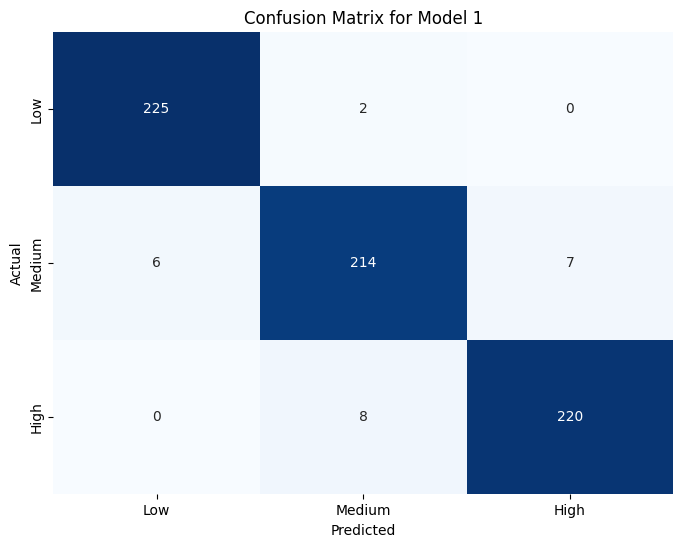

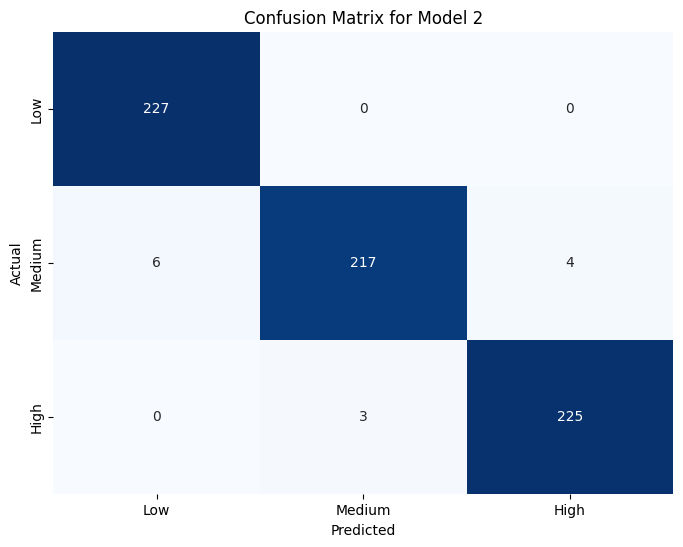

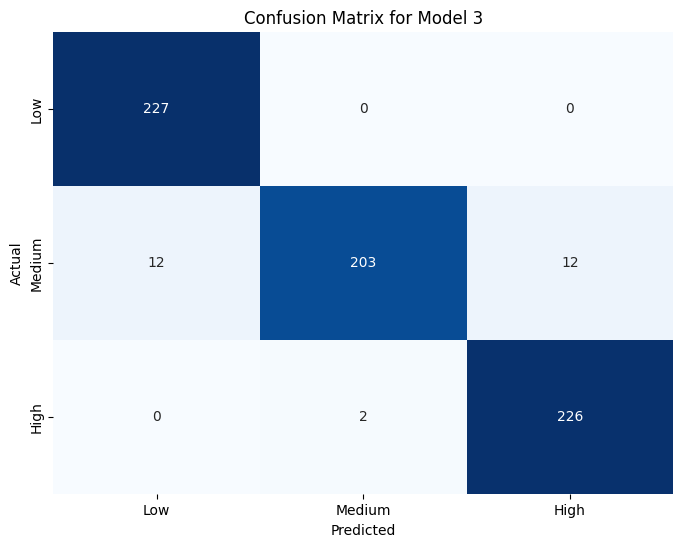

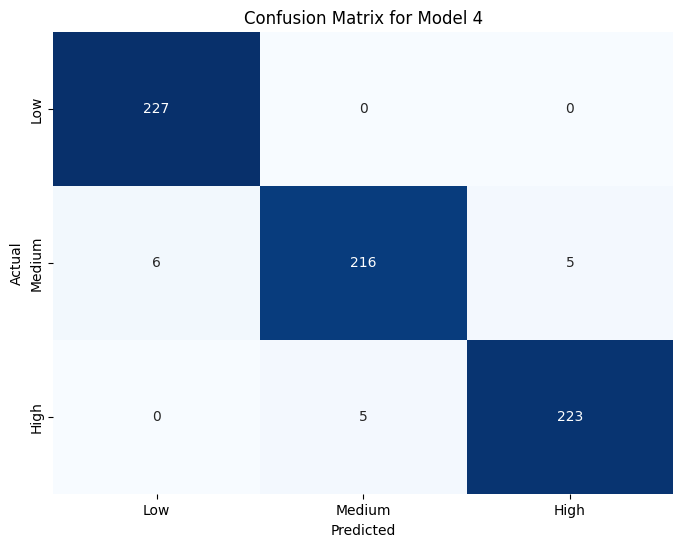

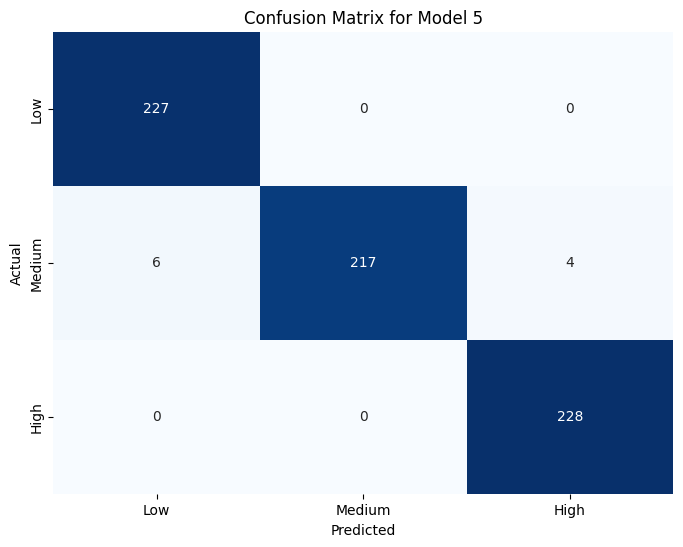

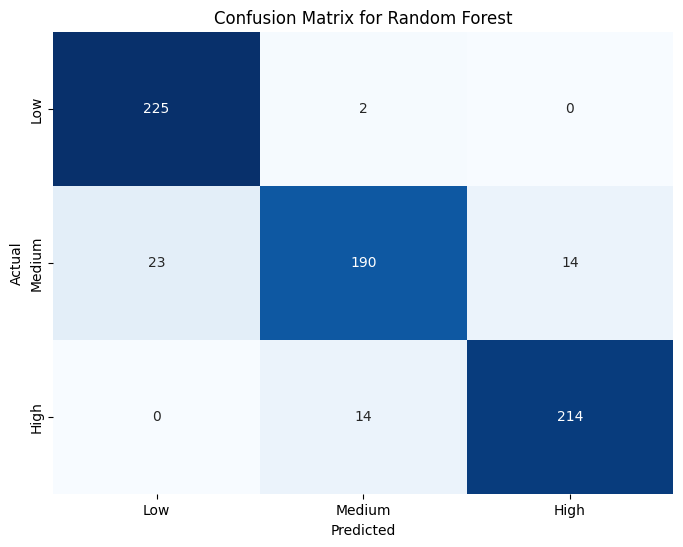

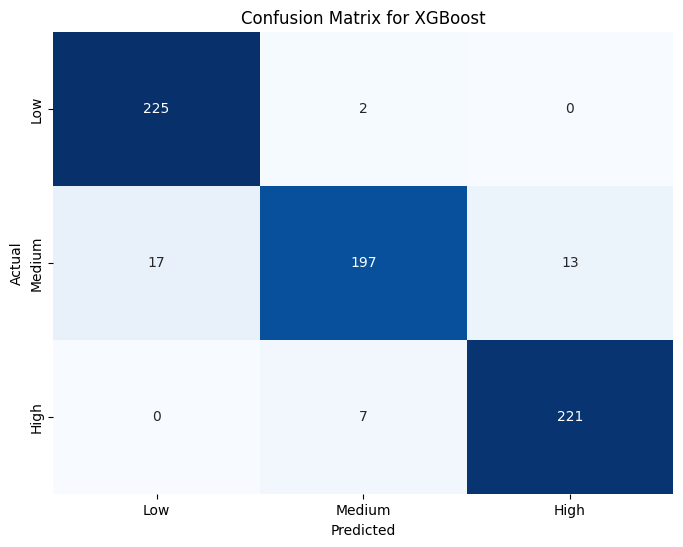

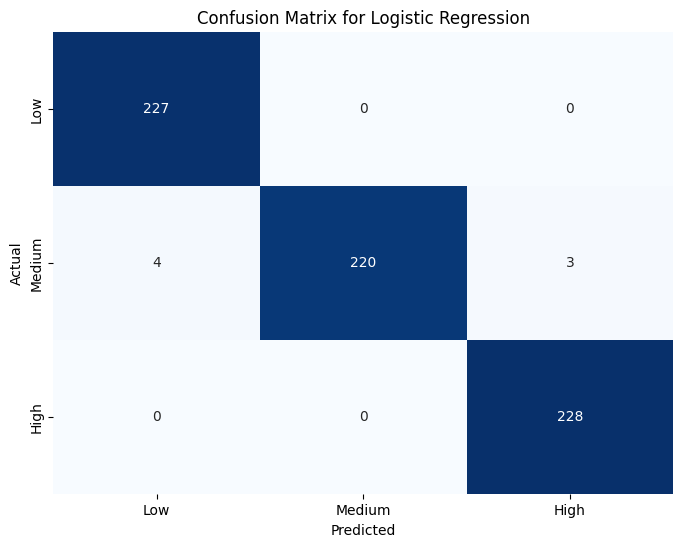

In [99]:
# Plot Confusion Matrices for All Models
for model_name, metrics in results.items():
    plot_confusion_matrix(metrics['Confusion Matrix'], model_name)

In [100]:
# Download the saved models directory
import shutil
from google.colab import files

# Step 1: Compress the folder
shutil.make_archive('saved_models', 'zip', 'saved_models')

# Step 2: Download the zip file
files.download('saved_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>